This part of assignment aims to provide you with some exposure to the use of autoencoders. Use
the full MNIST dataset for this problem.
Hints: Use corruption level = 0.1, training epochs = up to about 25, learning rate = 0.1, and batch
size = 128 for training of all the layers. 

### For an easier implementation we would like to implement most of the function in the class

In [1]:
import numpy as np
import theano


def init_weights(n_in, n_out, name_weight):
    weight = np.asarray(
        np.random.uniform(
            low=-4 * np.sqrt(6. / (n_in + n_out)),
            high=4 * np.sqrt(6. / (n_in + n_out)),
            size=(n_in, n_out)),
        dtype=theano.config.floatX)
    return theano.shared(value=weight, name=name_weight, borrow=True)


def init_bias(n, name_bias):
    return theano.shared(value=np.zeros(n, dtype=theano.config.floatX), name=name_bias, borrow=True)


def init_weight_biases_4dimension(filter_shape, d_type):
    fan_in = np.prod(filter_shape[1:])
    fan_out = filter_shape[0] * np.prod(filter_shape[2:])

    bound = np.sqrt(6. / (fan_in + fan_out))
    w_values = np.asarray(
        np.random.uniform(low=-bound, high=bound, size=filter_shape),
        dtype=d_type)
    b_values = np.zeros((filter_shape[0],), dtype=d_type)
    return theano.shared(w_values, borrow=True), theano.shared(b_values, borrow=True)


def init_weight_biases_2dimensions(filter_shape, d_type):
    fan_in = filter_shape[1]
    fan_out = filter_shape[0]

    bound = np.sqrt(6. / (fan_in + fan_out))
    w_values = np.asarray(
        np.random.uniform(low=-bound, high=bound, size=filter_shape),
        dtype=d_type)
    b_values = np.zeros((filter_shape[1],), dtype=d_type)
    return theano.shared(w_values, borrow=True), theano.shared(b_values, borrow=True)


def shuffle_data(samples, labels):
    idx = np.arange(samples.shape[0])
    np.random.shuffle(idx)
    samples, labels = samples[idx], labels[idx]
    return samples, labels


In [2]:
import numpy as np
import theano
import theano.tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

In [12]:
class SoftmaxAutoEncoder:
    def __init__(self, num_features, num_outputs, list_hidden_layer, learning_rate,
                 corruption_level=0.01,
                 sparsity_parameter=0.01, penalty_parameter=0.01):

        """
        :param list_hidden_layer: [10, 20] -> means 2 hidden layer, 10 neurons ->layer_1, 10 neurons -> layer_2
        :param corruption_level: made the noise in the data
        :param learning_rate: learning rate
        :param sparsity_parameter: 0.1 -> means 0.1 of neurons is activated
        :param penalty_parameter: learning decay
        """

        list_neurons = [num_features] + list_hidden_layer
        x = T.matrix('x')
        d = T.matrix('d')

        self.total_costs_auto_encoder = []
        self.total_costs_full = []
        self.total_predictions_full = []

        """
            Do the data corruption
        """

        x = self.corrupt_the_data(corruption_level=corruption_level, x=x)

        """
            Construct the auto encoder
        """

        weights = []
        biases = []

        prev_output = x

        """
            ENCODER
        """

        for i in range(1, len(list_neurons)):

            weight = init_weights(list_neurons[i-1], list_neurons[i], 'weight_%s' % i)
            bias = init_bias(list_neurons[i], 'bias_%s' % i)

            weights.append(weight)
            biases.append(bias)

            prev_output = T.nnet.sigmoid(T.dot(prev_output, weight) + bias)

        """
            DECODER
        """

        buffer_output = prev_output
        biases_trans = []

        for i in range(len(weights)-1, -1, -1):

            weight_transpose = weights[i].transpose()
            bias_transpose = init_bias(list_neurons[i], 'bias_trans_%s' % i)

            biases_trans.append(bias_transpose)

            prev_output = T.nnet.sigmoid(T.dot(prev_output, weight_transpose) + bias_transpose)

        cost = - T.mean(T.sum(x * T.log(prev_output) + (1 - x) * T.log(1 - prev_output), axis=1))

        params = weights+biases+biases_trans
        grads = T.grad(cost, params)
        updates = [(param, param - learning_rate*grad) for param, grad in zip(params, grads)]

        self.train_encoder = theano.function(
            inputs=[x],
            updates=updates,
            outputs=[prev_output, cost]
        )

        """
            TRAIN THE FULL CONNECTED LAYER
        """

        last_weight = init_weights(list_neurons[-1], num_outputs, 'last_weight')
        last_bias = init_bias(num_outputs, 'last_bias')

        buffer_output = T.nnet.softmax(T.dot(buffer_output, last_weight) + last_bias)
        y_pred = T.argmax(buffer_output, axis=1)

        cost_cross = T.mean(T.nnet.categorical_crossentropy(buffer_output, d))

        params_full = weights + [last_weight] + biases + [last_bias]
        grads_full = T.grad(cost_cross, params_full)
        updates_full = [(param, param - learning_rate * grad) for param, grad in zip(params_full, grads_full)]

        self.train_cross = theano.function(
            inputs=[x, d],
            updates=updates_full,
            outputs=[prev_output, y_pred, cost_cross]
        )

        self.test_cross = theano.function(
            inputs=[x],
            outputs=[y_pred]
        )

    def corrupt_the_data(self, corruption_level, x):

        # use binomial dist at corrupt the data
        rng = np.random.RandomState(123)
        theano_rng = RandomStreams(rng.randint(2 ** 30))

        tilde_x = theano_rng.binomial(size=x.shape, n=1, p=1 - corruption_level,
                                      dtype=theano.config.floatX) * x

        return tilde_x

    def start_train_auto_encoder(self, epochs, batch_size, train_x, train_y, verbose=False):

        print "Start training the auto encoder"

        for epoch in range(epochs):
            # go through trainng set

            costs = []
            results = []

            for start, end in zip(range(0, len(train_x), batch_size), range(batch_size, len(train_y), batch_size)):
                result, cost = self.train_encoder(train_x[start:end])
                costs.append(cost)
                results.append(result)

            self.total_costs_auto_encoder.append(np.mean(costs, dtype='float64'))

            if verbose:
                print "Epoch: %d Cost: %s \n" % (epoch, self.total_costs_auto_encoder[epoch])

    def start_train_the_full(self, epochs, batch_size, train_x, train_y, test_x, test_y):

        print "Start training the full hidden layer with autoencoder"

        for epoch in range(epochs):
            # go through trainng set
            costs = []
            results = []

            for start, end in zip(range(0, len(train_x), batch_size), range(batch_size, len(train_y), batch_size)):
                output, result, cost = self.train_cross(train_x[start:end], train_y[start:end])
                costs.append(cost)
                results.append(np.mean(np.argmax(test_y, axis=1) == self.test_cross(test_x)))

            self.total_costs_full.append(np.mean(costs, dtype='float64'))
            self.total_predictions_full.append(np.mean(results, dtype='float64'))
            print "result: %s, cost: %s \n" % (self.total_costs_full[epoch], self.total_predictions_full[epoch])

    def get_total_costs_of_auto_encoder(self):

        return self.total_costs_auto_encoder

    def get_total_cost_and_prediction_full(self):

        return self.total_costs_full, self.total_predictions_full


## Data Collections class

In [4]:
import cPickle

class DataCollector:

    def __init__(self, file_path):

        with open(file_path, "rb") as input_file:
            self.data = cPickle.load(input_file)

        self.data_train = self.data[0]
        self.data_test = self.data[2]
        self.data_validate = self.data[1]

    def get_train_data(self):

        return self.data_train[0], self.return_one_hot_encoding(10, self.data_train[1])

    def get_test_data(self):

        return self.data_test[0], self.return_one_hot_encoding(10, self.data_test[1])

    def get_validation_data(self):

        return self.data_validate[0], self.return_one_hot_encoding(10, self.data_validate[1])

    def return_one_hot_encoding(self, num_output, list_data):

        zeros = np.zeros((len(list_data), num_output))

        for i in range(len(zeros)):

            zeros[i][list_data[i]] = 1

        return zeros

## Plotting class

In [5]:
import matplotlib.pyplot as plt


class DataVisualization:

   def __init__(self):
       return

   def show_plot(self, list_x_point, list_y_point, x_label, y_label, title, figure_name):
       plt.figure()
       plt.plot(list_x_point, list_y_point)
       plt.xlabel(x_label)
       plt.ylabel(y_label)
       plt.title(title)
       plt.savefig(figure_name)
       plt.show()


class DataVisualizationWithLabels:
   def __init__(self):
       return

   def show_plot(self, list_x_point, list_y_point, x_label, y_label, title, figure_name, labels):
       plt.figure()

       for cnt in range(len(labels)):
           plt.plot(list_x_point[cnt], list_y_point[cnt], label=labels[cnt])

       plt.xlabel(x_label)
       plt.ylabel(y_label)
       plt.title(title)
       plt.legend()
       plt.savefig(figure_name)
       plt.show()

In [6]:
data_collector = DataCollector("../mnist.pkl")
data_visualize = DataVisualizationWithLabels()

train_x, train_y = data_collector.get_train_data()
test_x, test_y = data_collector.get_test_data()
validate_x, validate_y = data_collector.get_validation_data()

1) Design a stacked denoising autoencoder consisting of three hidden-layers; 900 neurons in the
first hidden-layer, 625 neurons in the second hidden-layer, and 400 neurons in the third
hidden-layer. To train the network:
- Use the training dataset of MNIST digits
- Corrupt the input data using a binomial distribution at 10% corruption level.
- Use cross-entropy as the cost function

Start training the auto encoder
Epoch: 0 Cost: 544.641947474 

Epoch: 1 Cost: 515.683312469 

Epoch: 2 Cost: 488.508844992 

Epoch: 3 Cost: 453.991500725 

Epoch: 4 Cost: 418.858746211 

Epoch: 5 Cost: 387.687735663 

Epoch: 6 Cost: 361.267816145 

Epoch: 7 Cost: 339.445162811 

Epoch: 8 Cost: 321.808586054 

Epoch: 9 Cost: 307.6935674 



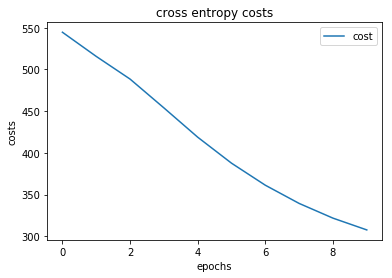

In [15]:
num_feature = len(train_x[0])
epochs = 10
batch_size = 20000
file_save = './images/1_cost.png'

softmax = SoftmaxAutoEncoder(num_features=num_feature, num_outputs=10,
                             list_hidden_layer=[10], learning_rate=0.05,
                            corruption_level=0.1)

softmax.start_train_auto_encoder(epochs=epochs, batch_size=batch_size, train_x=train_x, 
                                 train_y=train_y, verbose=True)

total_costs_auto_encoder = softmax.get_total_costs_of_auto_encoder()

len(total_costs_auto_encoder)
data_visualize.show_plot(
    list_y_point=[total_costs_auto_encoder], 
    list_x_point=[range(epochs)],
    x_label='epochs',
    y_label='costs',
    title='cross entropy costs',
    figure_name=file_save,
    labels=['cost']
)